### Author: Nathaniel Ruhl
### Date created: 01/29/2021
### Description: This notebook tracks the ISS orbit from the 180 degree point via a perfectly circular orbit in the perifocal frame


In [263]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table

# Read in the mkf file
tab_ni = Table.read('ni2200300102.mkf', hdu=1)
timeMKF = np.array(tab_ni['TIME'])
position = tab_ni['POSITION'] 
position_mag = np.array(np.sqrt((position[:,0])**2+(position[:,1])**2+(position[:,2])**2))
velocity = tab_ni['VELOCITY']
velocity_mag = np.array(np.sqrt((velocity[:,0])**2+(velocity[:,1])**2+(velocity[:,2])**2))

for col in range(3):
    velocity[:,col] = velocity[:,col]/velocity_mag
    position[:,col] = position[:,col]/position_mag

pole_vec = np.cross(position,velocity)

In [264]:
# Estimated time and position of ISS at the 180 degree point
t_180 = 192223307 # time0_offset-deltaT_50 from feb3_orbit_model.py
RA0 = np.deg2rad(95)
DEC0 = np.deg2rad(26) #i+delta_star

def RADECtoGEO(alpha, delta):
    x = np.array([np.cos(delta)*np.cos(alpha)])
    y = np.array([np.cos(delta)*np.sin(alpha)])
    z = np.array([np.sin(delta)])
    return np.array([x, y, z])

r0_ECI = RADECtoGEO(RA0, DEC0)

In [265]:
# Define constants

R = 6371
H = 420
T = 5569.5 ## 5574
omega_orb = 2 * np.pi / T  
theta = np.arcsin(R/(R+H))

# Calculate keplerian orbital elements from pole_vec and circular orbit
oldStartMKF = 2264
oldStopMKF = 2600
Omega = np.arccos(-pole_vec[oldStartMKF,1]) # Right ascenion of ascending node (2x check if + or - in arccos?)
i = np.arccos(pole_vec[oldStartMKF,2])
omega = 0 # Argument of perigee
print('Keplerian orbital elements on feb 3')
print('RAAN = ' + str(np.rad2deg(Omega)))
print('Inclination = ' + str(np.rad2deg(i)))
print('Argument of perigee = ' + str(np.rad2deg(omega)))

Keplerian orbital elements on feb 3
RAAN = 72.10117
Inclination = 51.54403
Argument of perigee = 0.0


In [266]:
# Define matrix to convert from ECI to perifocal frame

Q = np.array([[np.cos(Omega)*np.cos(omega)-np.sin(Omega)*np.sin(omega)*np.cos(i),np.sin(Omega)*np.cos(omega)+np.cos(Omega)*np.cos(i)*np.sin(omega),np.sin(i)*np.sin(Omega)],
             [-np.cos(Omega)*np.sin(omega)-np.sin(Omega)*np.cos(i)*np.cos(omega),-np.sin(Omega)*np.sin(omega)+np.cos(Omega)*np.cos(i)*np.cos(omega),np.sin(i)*np.cos(omega)],
             [np.sin(Omega)*np.sin(i),-np.cos(Omega)*np.sin(i),np.cos(i)]])

In [267]:
# This is a good sign that the z coordinate is zero
r0_Per = np.dot(Q,r0_ECI)/np.linalg.norm(np.dot(Q,r0_ECI))
print(r0_Per)

[[ 0.89951986]
 [ 0.4368788 ]
 [-0.00096321]]


In [290]:
# Create model orbit starting at r0_Per
phi = np.arange(0,2*np.pi/4,omega_orb) # Orbital Phase from 180 degree point to a quarter period later
t = t_180+(phi/omega_orb) # time array for mkf comparison

In [291]:
# Propogate the orbit over time, calculating r_Per at every step

r_Per = np.zeros((len(phi),3))

for row in range(len(phi)):
    for col in range(3):
        if (col == 0):
            r_Per[row,col]=np.cos(phi[row]) # x coordinate
        if (col == 1):
            r_Per[row,col]=np.sin(phi[row]) # y coordinate
        if (col == 2):
            r[row,col]=0 # z coordinate

# Convert position from perifocal frame to geocentric frame
                 
r_ECI = np.zeros((len(phi),3))

for row in range(len(phi)):
    r_ECI[row] = np.dot(np.matrix.transpose(Q),r_Per[row])


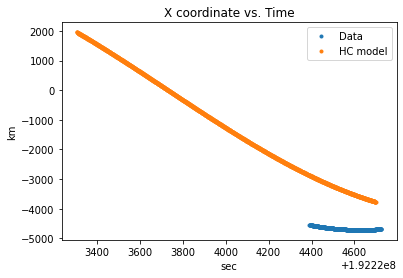

In [301]:
plt.title('X coordinate vs. Time')
plt.plot(timeMKF[oldStartMKF:oldStopMKF],position_mag[oldStartMKF:oldStopMKF]*position[oldStartMKF:oldStopMKF,0],'.',label='Data')
plt.plot(t,R*r_ECI[:,0],'.',label='HC model')
plt.ylabel('km')
plt.xlabel('sec')
plt.legend()

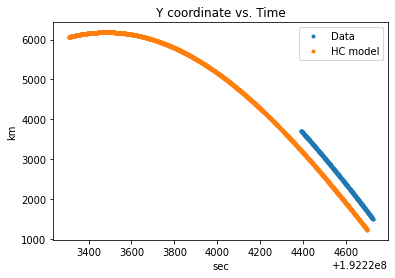

In [300]:
plt.title('Y coordinate vs. Time')
plt.plot(timeMKF[oldStartMKF:oldStopMKF],position_mag[oldStartMKF:oldStopMKF]*position[oldStartMKF:oldStopMKF,1],'.',label='Data')
plt.plot(t,R*r_ECI[:,1],'.',label='HC model')
plt.ylabel('km')
plt.xlabel('sec')
plt.legend()

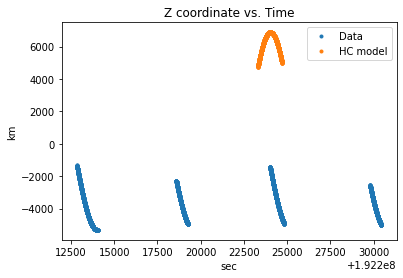

In [299]:
plt.title('Z coordinate vs. Time')
plt.plot(timeMKF,position_mag*position[:,2],'.',label='Data')
plt.plot(t,R*r_ECI[:,2],'.',label='HC model')
plt.ylabel('km')
plt.xlabel('sec')
plt.legend()

In [315]:
t1_index_model = np.where(t>timeMKF[oldStartMKF])[0][0] # index when the model meets up with the data

In [326]:
print('Accuracy of model at t1:')
print('X: ' + str(int(np.abs(position_mag[oldStartMKF]*position[oldStartMKF,0]-R*r_ECI[t1_index_model,0]))) + 'km')
print('Y: ' + str(int(np.abs(position_mag[oldStartMKF]*position[oldStartMKF,1]-R*r_ECI[t1_index_model,1]))) + 'km')
print('Z: ' + str(int(np.abs(position_mag[oldStartMKF]*position[oldStartMKF,2]-R*r_ECI[t1_index_model,2]))) + 'km')

Accuracy of model at t1:
X: 1668km
Y: 498km
Z: 9740km


After improving this  method, a possible next step is to calculate the velocity from our calculation. It may be hard to get a highly accurate position with this method, but if improved, it looks extremely promising. If we can get the X and Z plots looking like the Y plot, the velocity vector (slop of position) should be almost exact. We can then use this velocity as an input to either the pointing vector basis change method I developed and/or r=cross(v,w). This should produce a highly accurate position vector.